[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v2.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Предсказание

In [5]:
import json
import os
#import numpy as np 
#import pandas as pd 
import random
#import time

#import cv2
import torch
#import torch.utils.data
#from torch.utils.data import Dataset, DataLoader
import torchvision
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

from PIL import Image
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches

#from pycocotools.coco import COCO
import fiftyone as fo

In [16]:
img_path = 'data'

def load_model_detection(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')
num_classes = 2
model = load_model_detection(num_classes)
model.to(device)
checkpoint = torch.load('checkpoints/model_detector_resnet50_3.pth')
model.load_state_dict(checkpoint['model_state_dict'])

ValueError: Unknown value 'checkpoints/model_detector_resnet50_3.pth' for FasterRCNN_ResNet50_FPN_Weights.

In [8]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

def get_prediction(img_path, img_name, threshold):
    model.eval()
    img = Image.open(os.path.join(img_path, img_name))
    transforms=get_transform()
    img = transforms(img).to(device)
    prediction = model([img])
    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction[0]['boxes'].detach().cpu().numpy())]
    pred_labels = list(prediction[0].get('labels').cpu().numpy())
    pred_scores = list(prediction[0].get('scores').detach().cpu().numpy())
    pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
    pred_labels = pred_labels[:pred_tr+1]
    pred_boxes = pred_boxes[:pred_tr+1]
    pred_scores = pred_scores[:pred_tr+1]
    
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return pred_boxes, pred_labels, pred_scores

img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
threshold = 0.1
prediction = get_prediction(img_path, img_name, threshold)
prediction

([[1146.6887, 11.962307, 1276.5957, 150.06093]], [1], [0.9467205])

In [7]:
def get_random_val_image_name():
    dataset_path = img_path
    with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
        val_anno = json.load(read_file)
    read_file.close()
    img_name = val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')
    return img_name

def get_predict_anno(images_path, img_name, threshold):

    if img_name == None:
        img_name = get_random_val_image_name()


    pred_boxes, pred_labels, pred_scores = get_prediction(images_path, img_name, threshold)
    
    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(images_path, img_name))
    transforms=get_transform()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
        anno_item['area'] = (float(pred_boxes[i][2]) - float(pred_boxes[i][0]))*(float(pred_boxes[i][3]) - float(pred_boxes[i][1]))
        anno_item['bbox'] = [float(pred_boxes[i][0]), float(pred_boxes[i][1]), float(pred_boxes[i][2]) - float(pred_boxes[i][0]), float(pred_boxes[i][3]) - float(pred_boxes[i][1])]
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)
    anno['annotations'] = annotations
    
    anno['categories'] = [{'id': 1, 'name': 'sign'}]

    with open(os.path.join(img_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()



    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(img_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return anno


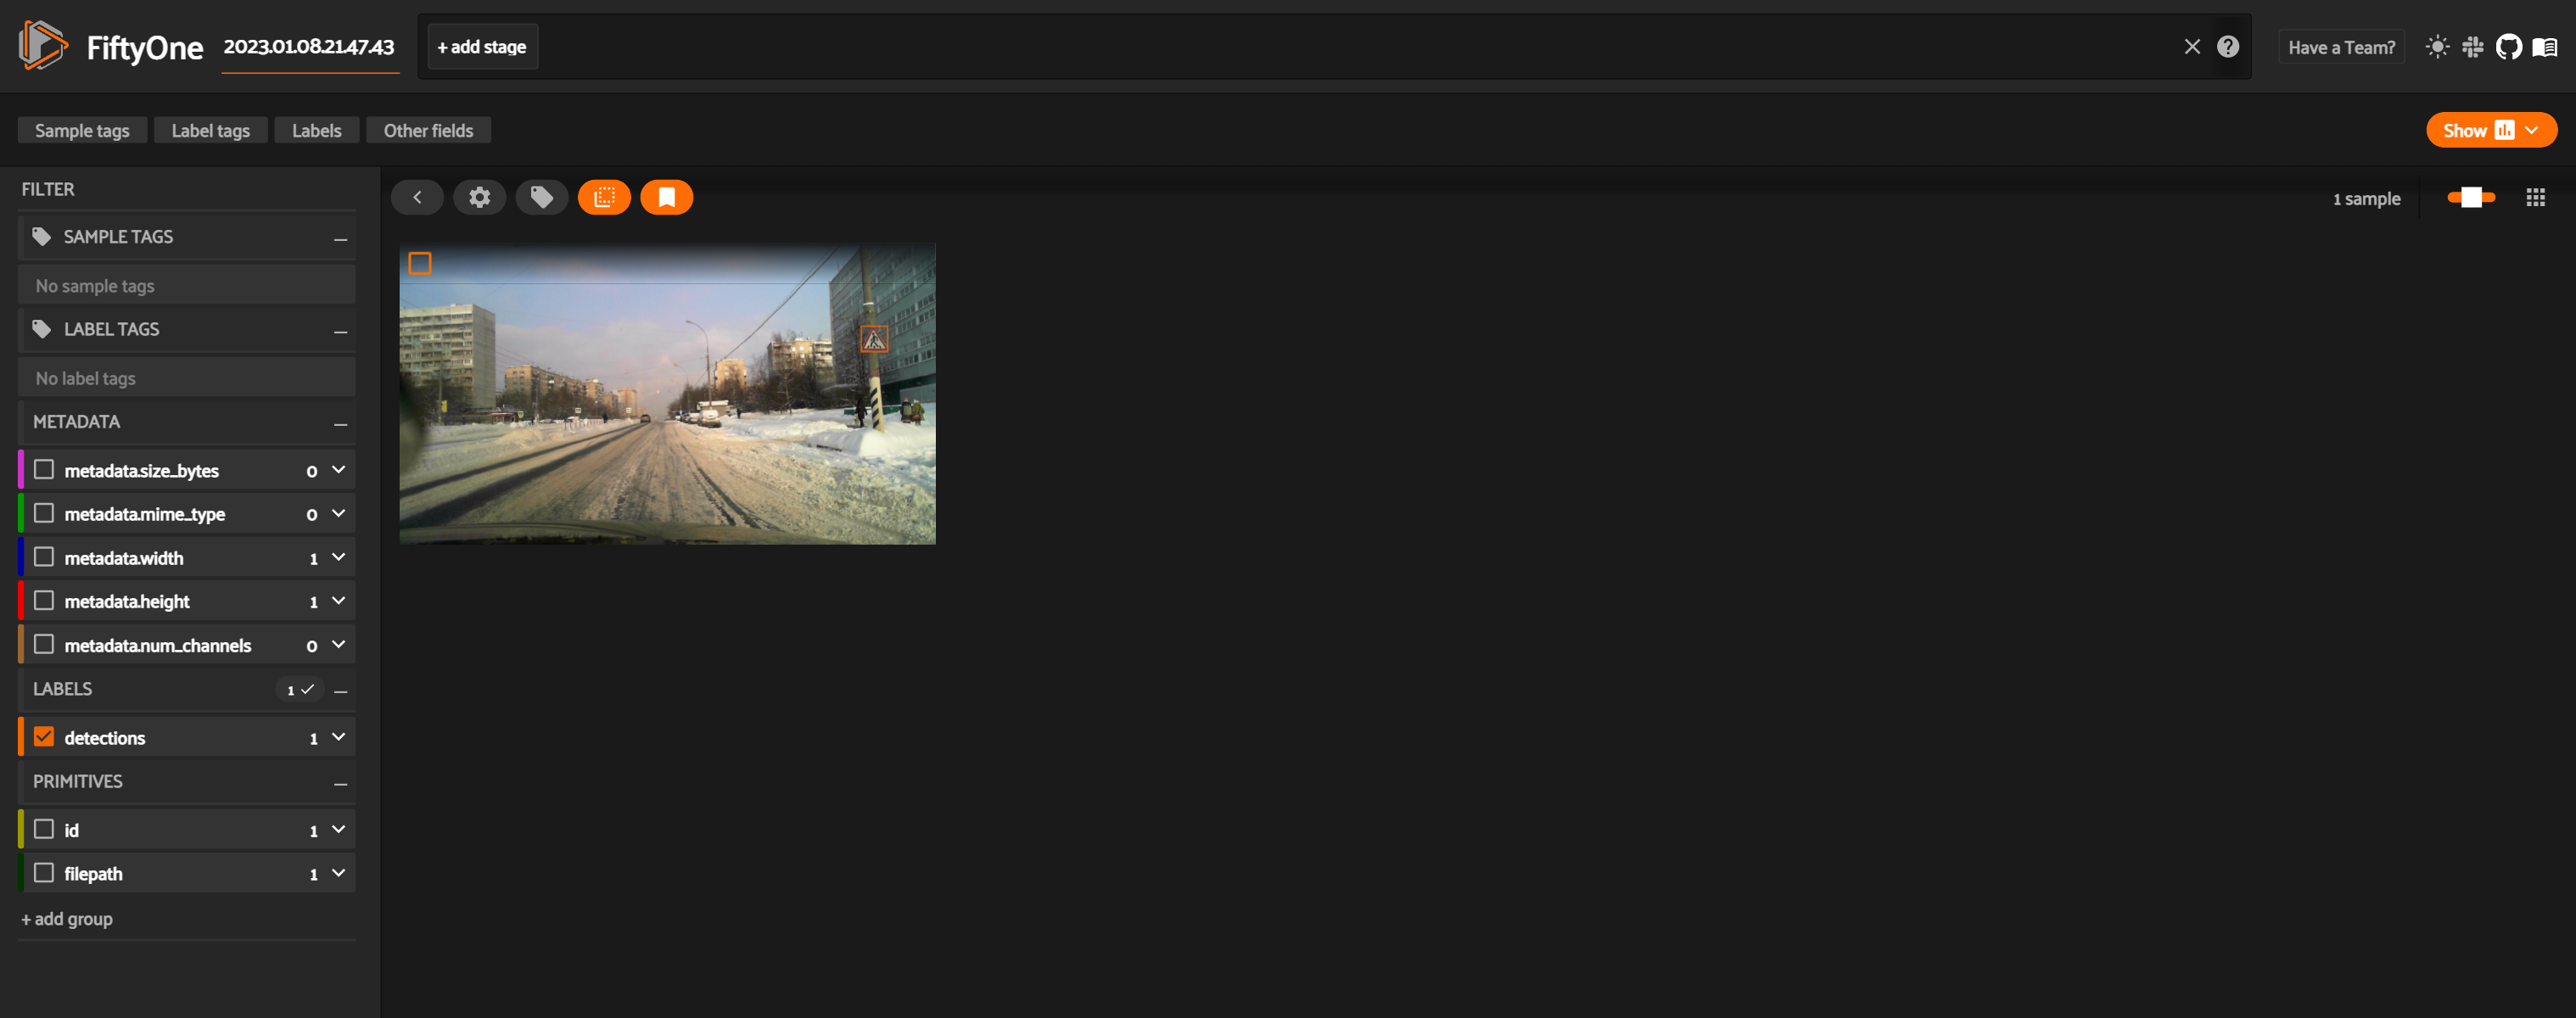

In [29]:
threshold = 0.7
#img_name = 'rtsd-frames/autosave13_04_2013_09_48_32_2.jpg'
prediction_anno = get_predict_anno(img_path, None, threshold)

 100% |█████████████████████| 1/1 [38.6ms elapsed, 0s remaining, 26.8 samples/s] 



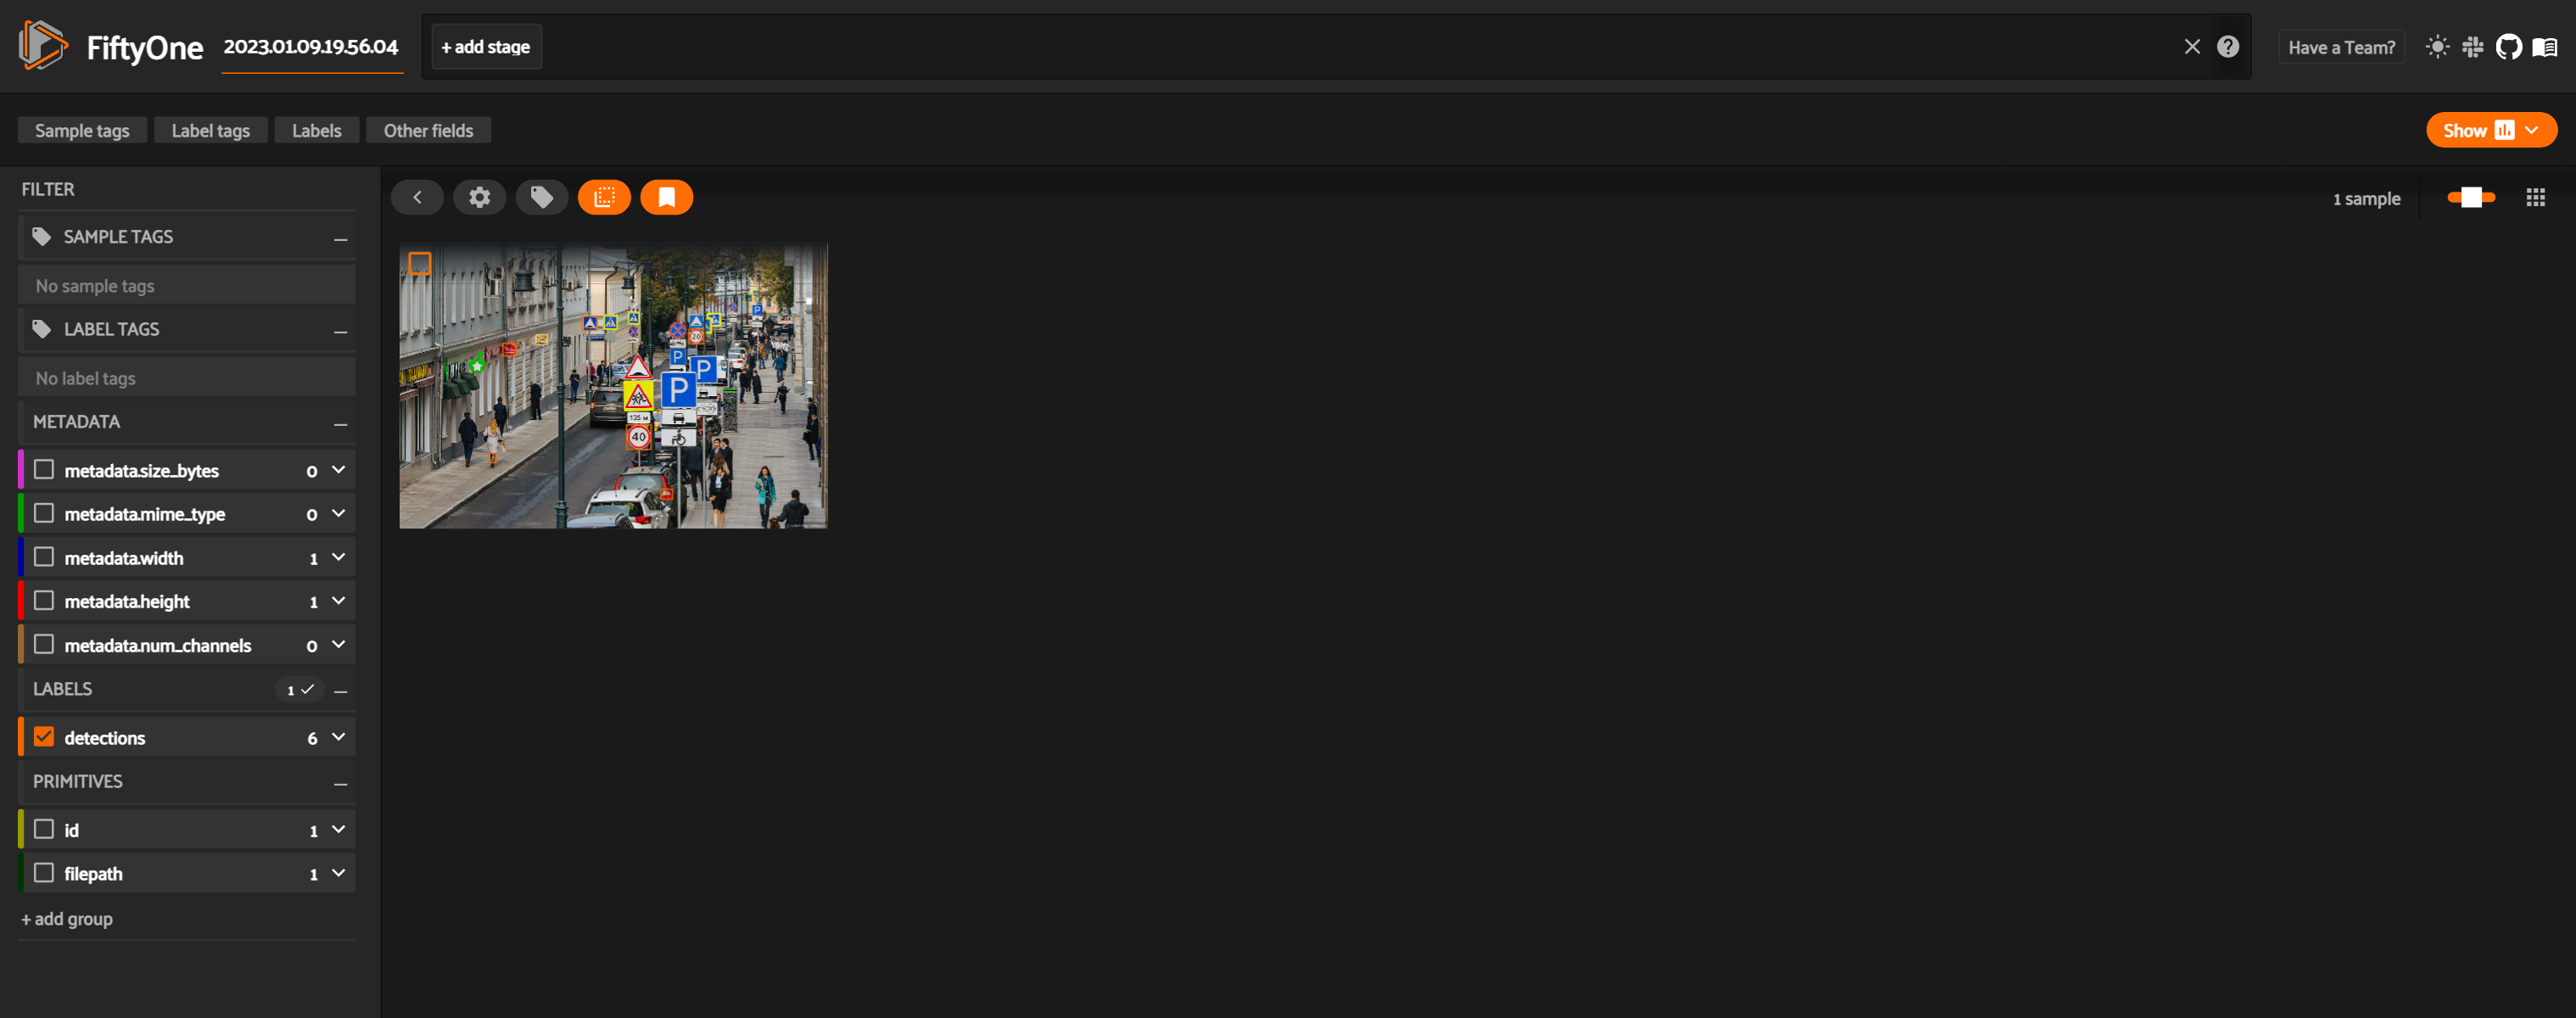

In [9]:
img_name = 'image_for_predict/image1.jpg'
threshold = 0.5
prediction_anno = get_predict_anno(img_path, img_name, threshold)

 100% |█████████████████████| 1/1 [22.0ms elapsed, 0s remaining, 47.7 samples/s] 



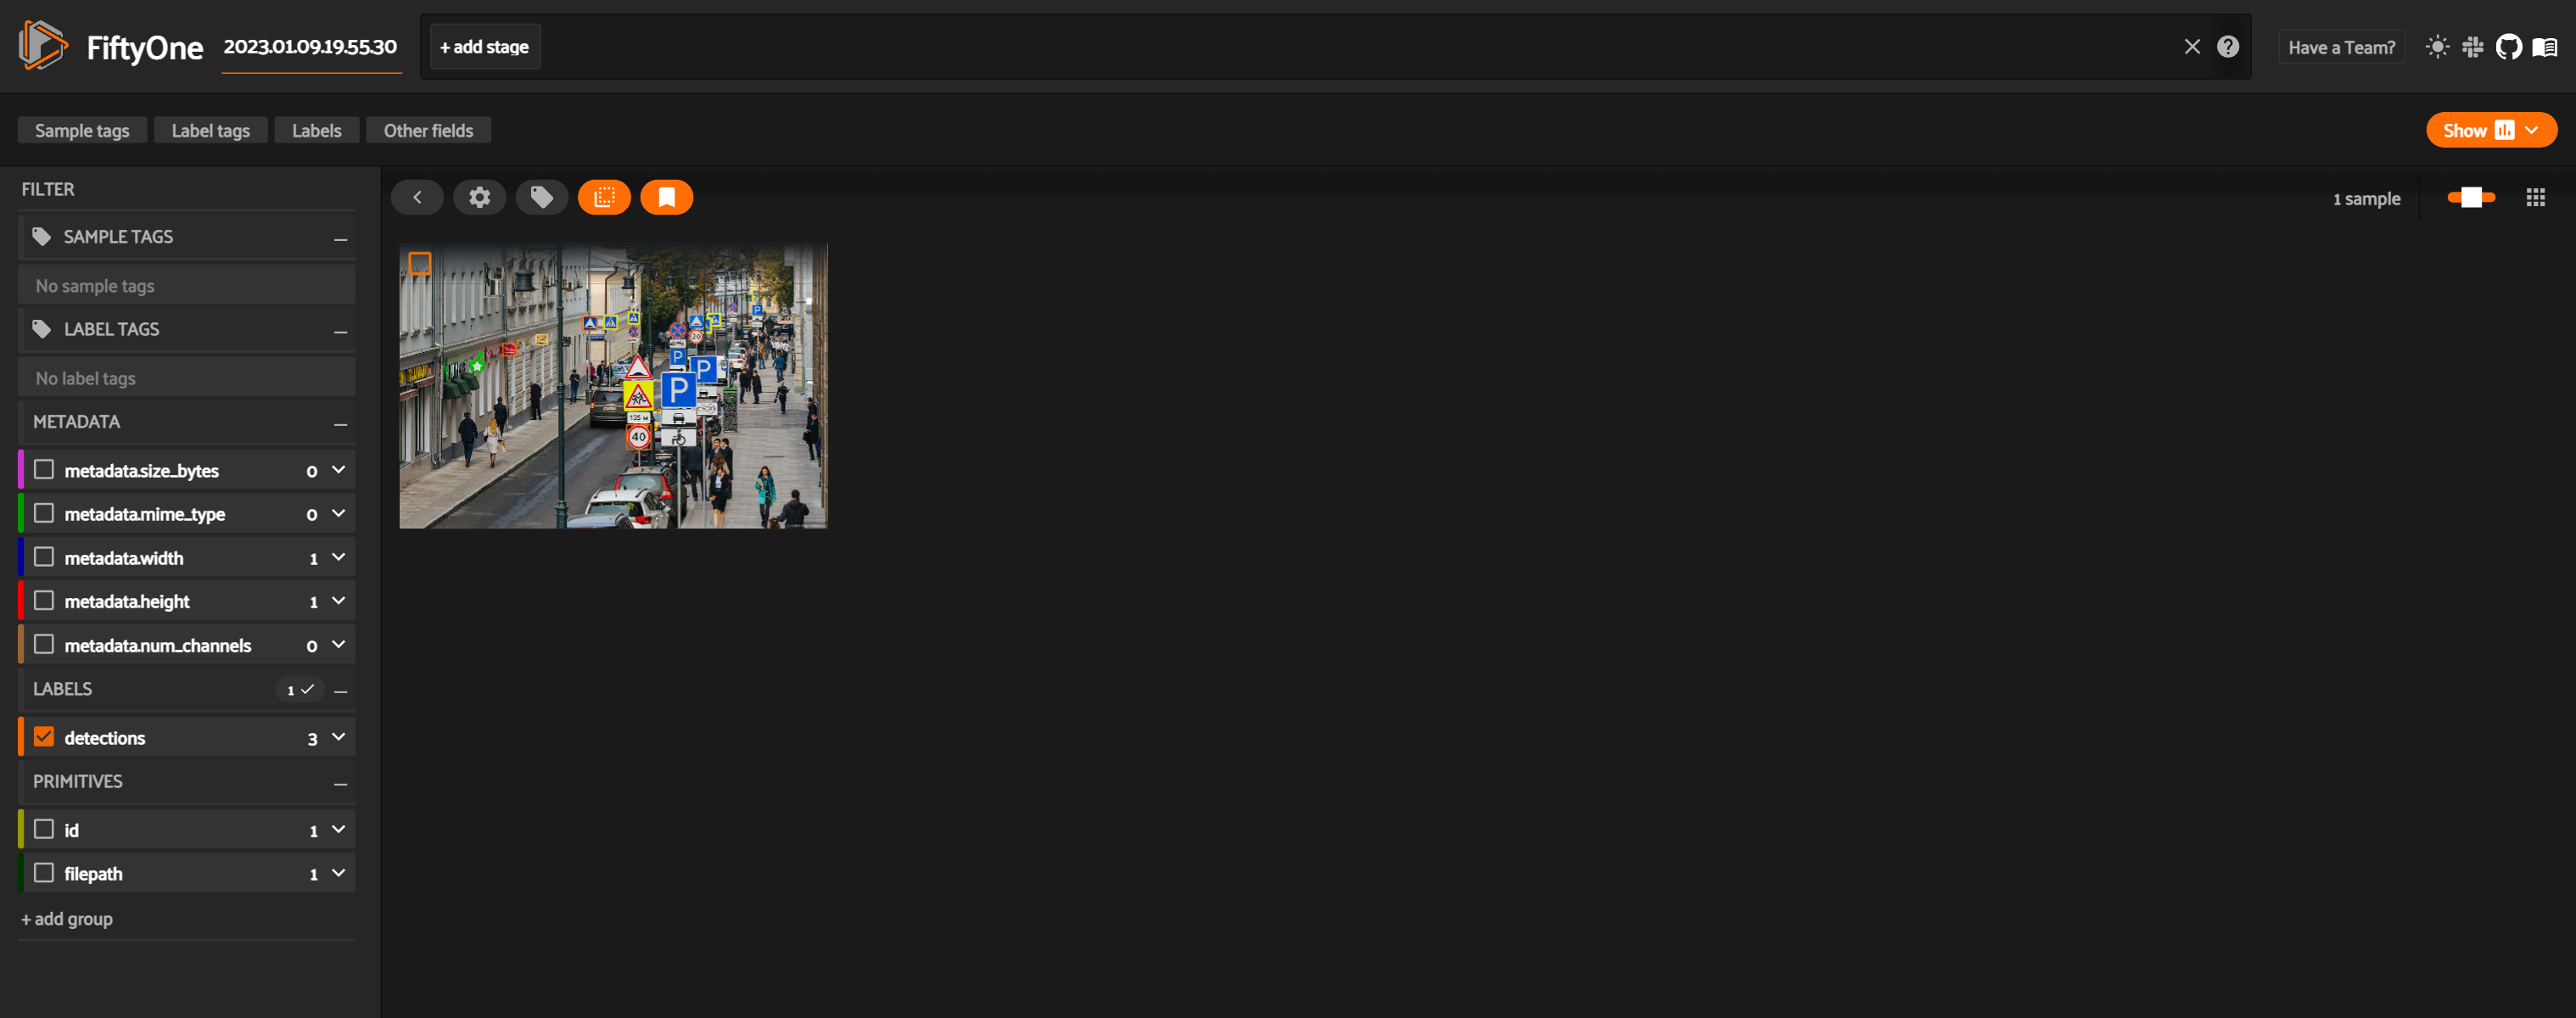


Could not connect session, trying again in 10 seconds



In [10]:
img_name = 'image_for_predict/image2.jpg'
threshold = 0.7
prediction_anno = get_predict_anno(img_path, img_name, threshold)

 100% |█████████████████████| 1/1 [27.0ms elapsed, 0s remaining, 39.5 samples/s] 



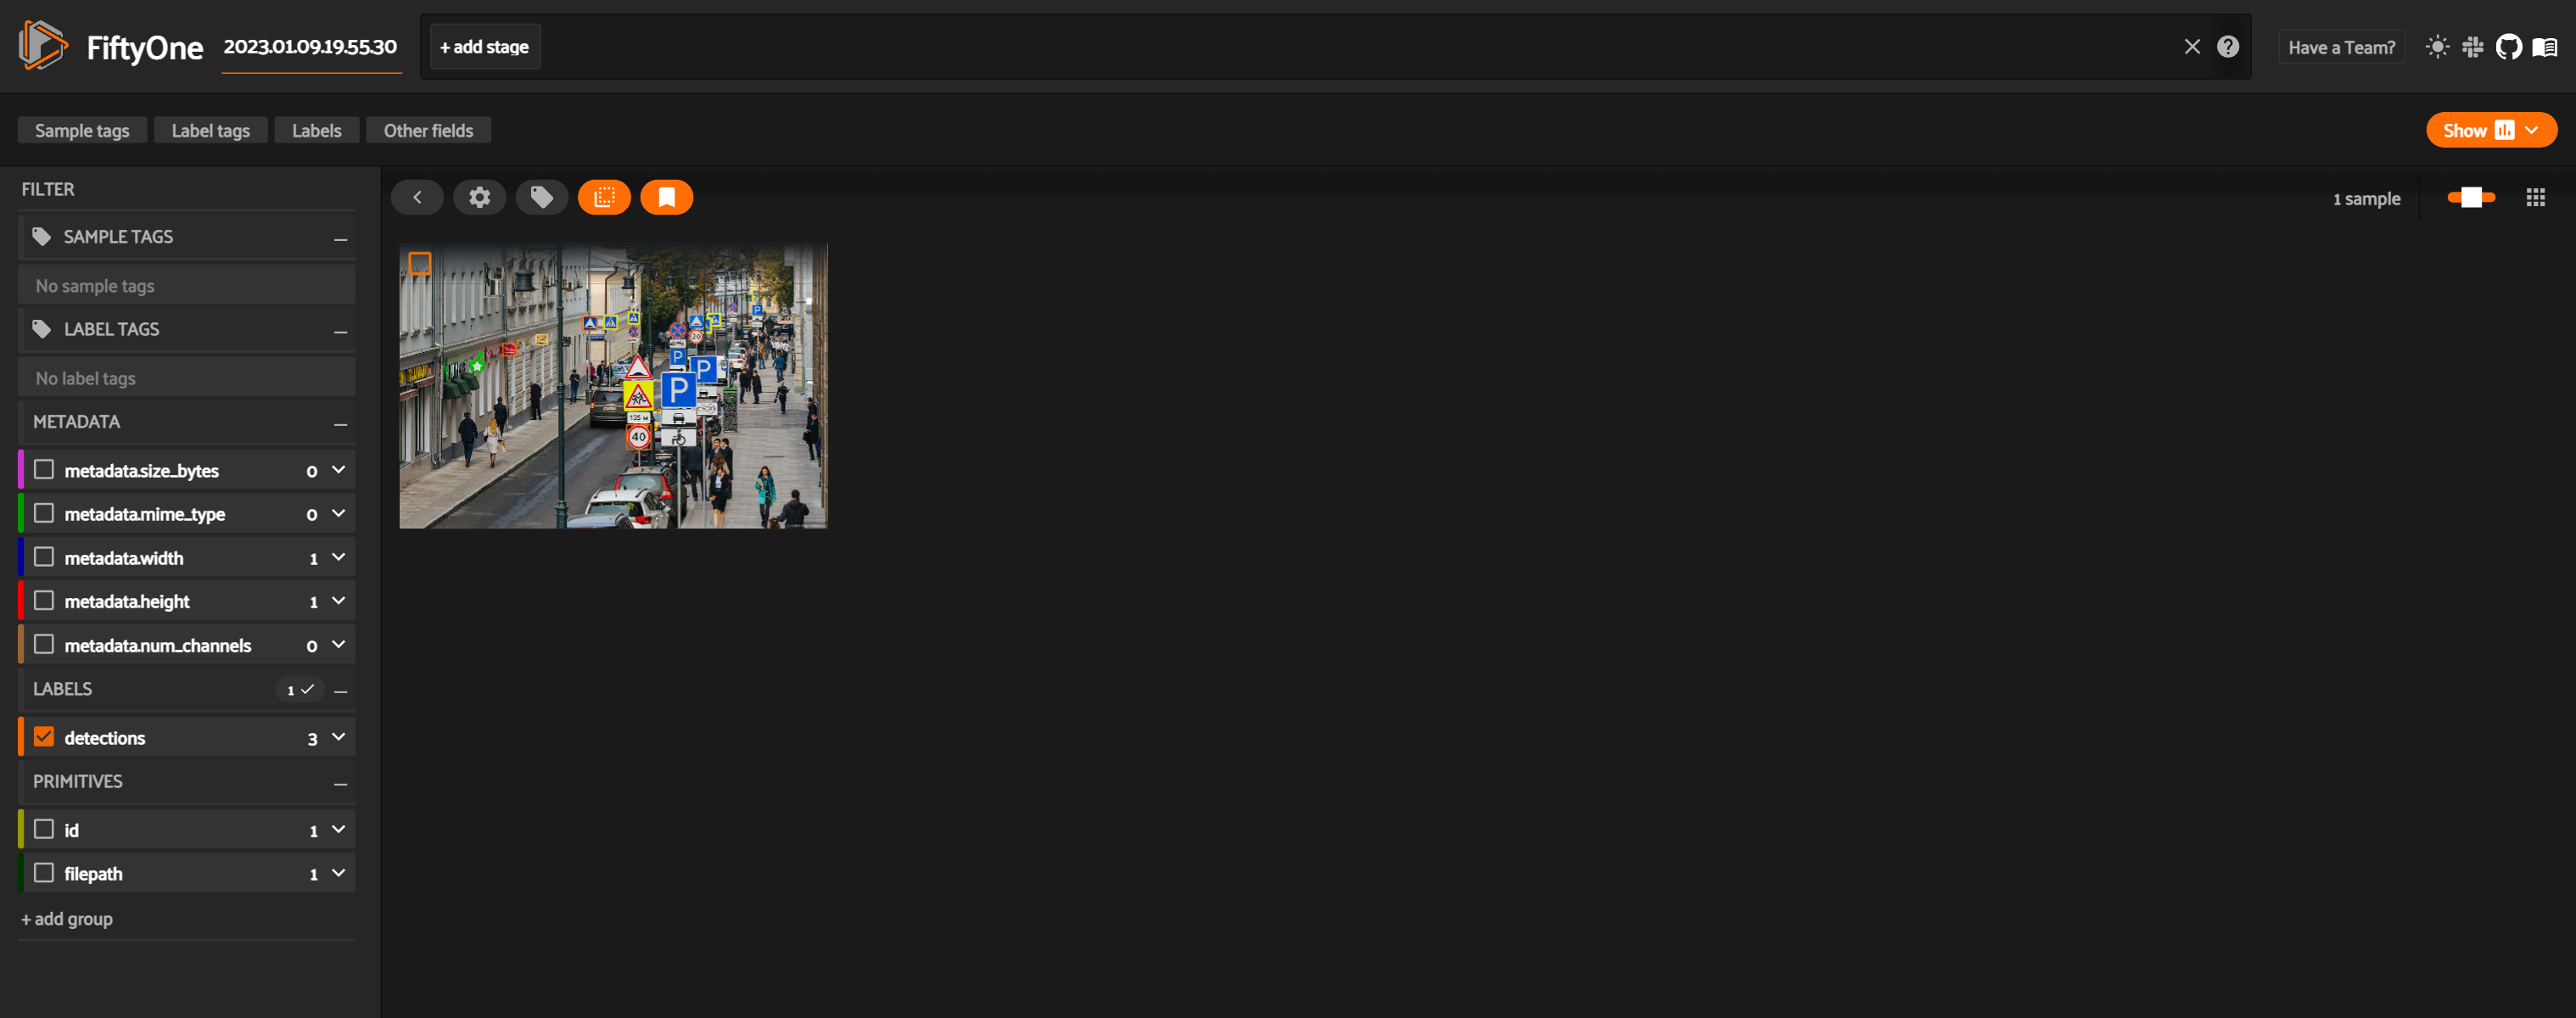


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [11]:
img_name = 'image_for_predict/screen1.jpg'
threshold = 0.7
prediction_anno = get_predict_anno(img_path, img_name, threshold)

In [21]:
img_name = 'image_for_predict/screen2.jpg'
threshold = 0.1
prediction_anno = get_predict_anno(img_path, img_name, threshold)

 100% |█████████████████████| 1/1 [26.9ms elapsed, 0s remaining, 39.3 samples/s] 


In [ ]:
#Сравнение предскаханий на валидационной выборке и истинных значений

In [4]:
import fiftyone as fo


# загрузка датасета

# The directiry containing the source images
data_path = img_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
labels_file = "val_anno_bin_class.json"
labels_path = os.path.join(data_path, labels_file)


# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path
)

 100% |███████████████| 5000/5000 [9.3s elapsed, 0s remaining, 614.9 samples/s]       


In [18]:
import fiftyone.zoo as foz
# Предсказание на предобученной моделе
# List available zoo models
model_names = foz.list_zoo_models()
print(model_names)


#
# Load zoo model
#
# This will download the model from the web, if necessary, and ensure
# that any required packages are installed
#
model = foz.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")

['alexnet-imagenet-torch', 'centernet-hg104-1024-coco-tf2', 'centernet-hg104-512-coco-tf2', 'centernet-mobilenet-v2-fpn-512-coco-tf2', 'centernet-resnet101-v1-fpn-512-coco-tf2', 'centernet-resnet50-v1-fpn-512-coco-tf2', 'centernet-resnet50-v2-512-coco-tf2', 'clip-vit-base32-torch', 'deeplabv3-cityscapes-tf', 'deeplabv3-mnv2-cityscapes-tf', 'deeplabv3-resnet101-coco-torch', 'deeplabv3-resnet50-coco-torch', 'densenet121-imagenet-torch', 'densenet161-imagenet-torch', 'densenet169-imagenet-torch', 'densenet201-imagenet-torch', 'efficientdet-d0-512-coco-tf2', 'efficientdet-d0-coco-tf1', 'efficientdet-d1-640-coco-tf2', 'efficientdet-d1-coco-tf1', 'efficientdet-d2-768-coco-tf2', 'efficientdet-d2-coco-tf1', 'efficientdet-d3-896-coco-tf2', 'efficientdet-d3-coco-tf1', 'efficientdet-d4-1024-coco-tf2', 'efficientdet-d4-coco-tf1', 'efficientdet-d5-1280-coco-tf2', 'efficientdet-d5-coco-tf1', 'efficientdet-d6-1280-coco-tf2', 'efficientdet-d6-coco-tf1', 'efficientdet-d7-1536-coco-tf2', 'faster-rcnn-in

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model.state_dict()

AttributeError: 'TorchvisionImageModel' object has no attribute 'state_dict'

In [14]:
checkpoint = torch.load('checkpoints/model_detector_resnet50_3.pth')
model.load_state_dict(checkpoint['model_state_dict'])

AttributeError: 'TorchvisionImageModel' object has no attribute 'load_state_dict'

In [9]:


#
# Load some samples from the COCO-2017 validation split
#
# This will download the dataset from the web, if necessary
#
#dataset = foz.load_zoo_dataset(
#    "coco-2017",
#    split="validation",
#    dataset_name="coco-2017-validation-sample",
#    max_samples=50,
#    shuffle=True,
#)

#
# Choose some samples to process. This can be the entire dataset, or a
# subset of the dataset. In this case, we'll choose some samples at
# random
#
samples = dataset.take(25)

#
# Generate predictions for each sample and store the results in the
# `faster_rcnn` field of the dataset, discarding all predictions with
# confidence below 0.5
#
samples.apply_model(model, label_field="faster_rcnn", confidence_thresh=0.5)
print(samples)

# Visualize predictions in the App
session = fo.launch_app(view=samples)

ValueError: Model must be a <class 'fiftyone.core.models.Model'> or flash.core.model.Task; found <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>